# Předpokládaná délka života

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import optimize
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor


import matplotlib.colors as colors
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import seaborn as sns
rd_seed = 42
import warnings

## Předzpracování dat

### Načtení dat, rozdělení do množin

In [2]:
data = pd.read_csv('data.csv')

In [3]:
def splitData(data, y_collumn):
    Xdata = data.drop(y_collumn, axis=1)
    ydata = data[y_collumn]
    Xtrain, Xtest, ytrain, ytest = train_test_split(
        Xdata, ydata, test_size=0.3, random_state=rd_seed
    )
    Xval, Xtest, yval, ytest = train_test_split(
        Xtest, ytest, test_size=0.5, random_state=rd_seed
    )
    return Xtrain, ytrain, Xval, yval, Xtest, ytest

In [4]:
Xtrain, ytrain, Xval, yval, Xtest, ytest = splitData(data, 'Life expectancy')

In [5]:
display(Xtrain.info())
display(Xtrain.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1902 entries, 1850 to 860
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          1902 non-null   object 
 1   Year                             1902 non-null   int64  
 2   Status                           1902 non-null   object 
 3   Adult Mortality                  1902 non-null   float64
 4   infant deaths                    1902 non-null   int64  
 5   Alcohol                          1792 non-null   float64
 6   percentage expenditure           1902 non-null   float64
 7   Hepatitis B                      1522 non-null   float64
 8   Measles                          1902 non-null   int64  
 9   BMI                              1877 non-null   float64
 10  under-five deaths                1902 non-null   int64  
 11  Polio                            1887 non-null   float64
 12  Total expenditure 

None

,Country,Year,Status,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
1850,Peru,2009,Developing,14.0,10,4.69,570.453247,93.0,0,51.5,...,92.0,5.36,93.0,0.3,4166.933870,29157.0,1.2,1.2,0.706,13.3
1601,Montenegro,2004,Developing,134.0,0,0.01,57.121901,NaN,0,55.0,...,NaN,8.45,NaN,0.1,338.199535,613353.0,2.3,2.4,0.740,12.6
281,Bhutan,2004,Developing,263.0,1,0.96,2.586698,89.0,3,16.1,...,9.0,4.41,89.0,0.3,197.457880,64282.0,18.0,18.8,0.000,8.8
2382,The former Yugoslav republic of Macedonia,2011,Developing,17.0,0,1.16,0.000000,96.0,701,57.9,...,97.0,6.61,96.0,0.1,NaN,NaN,2.2,2.3,0.735,12.9
1025,Guyana,2010,Developing,221.0,0,7.52,48.028594,95.0,0,42.4,...,95.0,6.60,95.0,0.4,326.281212,746556.0,5.6,5.3,0.618,10.2


### Analýza sloupců

Provedu základní analýzu hodnot ve sloupcích. 

In [6]:
def missingValuesGraph(df, name):
    fig, ax = plt.subplots(figsize=(16, 6))
    cmap = colors.ListedColormap(["darkslategrey", "white"])
    ax.imshow(
        df.isna(),
        aspect="auto",
        cmap=cmap,
        interpolation="none",
        vmin=0,
        vmax=1,
    )
    ax.set_xlabel("Columns")
    ax.set_ylabel("Rows Index")

    num_columns = len(df.columns)

    ax.set_xticks(np.arange(num_columns))
    ax.tick_params(axis="x", which="major", length=0)
    ax.set_xticklabels(df.columns, rotation=45, ha="right")

    ax.set_xticks(np.arange(0.5, num_columns + 0.5, 1), minor=True)

    legend_elements = [
        Patch(facecolor="darkslategrey", edgecolor="black", label="Present Value"),
        Patch(facecolor="white", edgecolor="black", label="Missing Value"),
    ]

    ax.legend(
        handles=legend_elements,
        loc="upper right",
        bbox_to_anchor=(1.05, -0.1),
        borderaxespad=0.0,
    )

    ax.grid(
        which="minor",
        visible=True,
        axis="x",
        color="white",
        linestyle="-",
        linewidth=1.0,
    )
    ax.grid(
        which="major",
        visible=False,
        axis="x",
    )

    ax.grid(
        which="major",
        visible=False,
        axis="y",
    )

    ax.set_yticks(range(0, len(df), max(1, len(df) // 5)))
    ax.set_title(f"Missing Values in {name}")

def hist_box(df, cont_col, bins):
    fig, ax = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [3, 1]})

    sns.histplot(df[cont_col], bins=bins, kde=False, ax=ax[0])
    ax[0].set_title(f"{cont_col.capitalize()} Distribution in Dataset")
    ax[0].set_xlabel(cont_col.capitalize())
    ax[0].set_ylabel("Frequency")

    sns.boxplot(x=df[cont_col], ax=ax[1])
    ax[1].set_title(f"Box Plot of {cont_col.capitalize()} in Dataset")
    ax[1].set_xlabel(cont_col.capitalize())

    plt.tight_layout()
    plt.show()
    display(df[cont_col].describe())

,Year,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,1902.000000,1902.000000,1902.000000,1792.000000,1902.000000,1522.000000,1902.000000,1877.000000,1902.000000,1887.000000,1771.000000,1887.000000,1902.000000,1621.000000,1.476000e+03,1877.000000,1877.000000,1808.000000,1808.000000
mean,2007.032072,162.570452,27.290221,4.657121,789.101154,81.031537,2633.532072,37.897123,37.954259,82.750397,5.919842,82.644409,1.785804,7750.165574,1.294841e+07,4.867608,4.905541,0.622949,11.945962
std,4.514460,122.351358,100.168296,4.027523,2080.583865,24.953217,12590.979369,19.711130,138.014639,23.273985,2.431503,23.393680,5.216238,14771.947402,5.912371e+07,4.386510,4.461883,0.217410,3.393316
min,2000.000000,1.000000,0.000000,0.010000,0.000000,2.000000,0.000000,1.000000,0.000000,3.000000,0.370000,3.000000,0.100000,1.681350,3.600000e+01,0.100000,0.100000,0.000000,0.000000
25%,2003.000000,73.000000,0.000000,1.030000,5.885202,77.000000,0.000000,19.000000,0.000000,78.000000,4.240000,79.000000,0.100000,453.351155,1.989615e+05,1.600000,1.600000,0.488000,10.200000
50%,2007.000000,143.000000,3.000000,3.875000,70.884857,92.000000,18.000000,43.000000,4.000000,93.000000,5.770000,93.000000,0.100000,1855.939150,1.396804e+06,3.400000,3.400000,0.675000,12.300000
75%,2011.000000,225.000000,22.000000,7.742500,460.264412,97.000000,404.500000,55.800000,29.000000,97.000000,7.530000,97.000000,0.700000,6268.692122,7.414499e+06,7.100000,7.200000,0.778250,14.200000
max,2015.000000,723.000000,1700.000000,17.870000,19099.045060,99.000000,212183.000000,76.700000,2300.000000,99.000000,17.000000,99.000000,50.600000,119172.741800,1.179681e+09,27.400000,28.400000,0.938000,20.600000


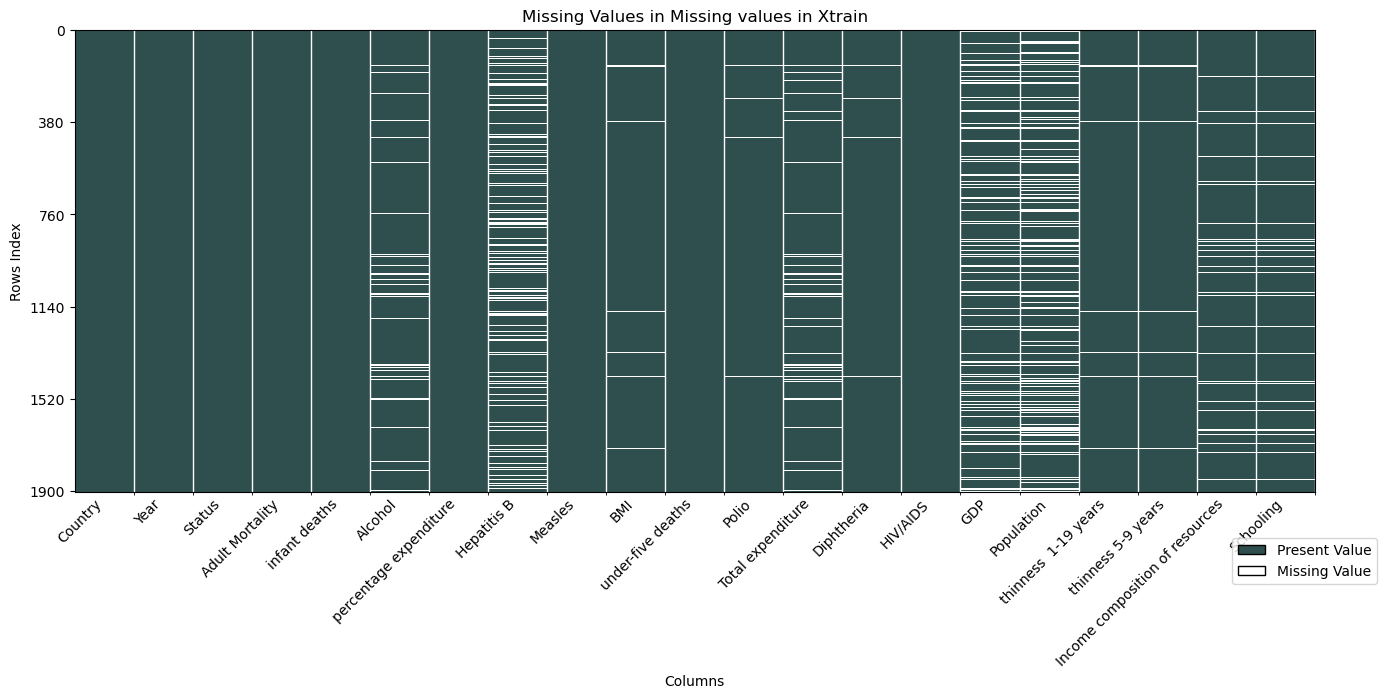

In [7]:
missingValuesGraph(Xtrain, "Missing values in Xtrain")
display(Xtrain.describe())

Dataset obsahuje chybějící hodnoty. Číselné příznaky, které mají různé rozsahy a distribuci. Nejvíc hodnot chybí ve sloupci Population.

['Developing' 'Developed']
Developing    1583
Developed      319
Name: Status, dtype: int64


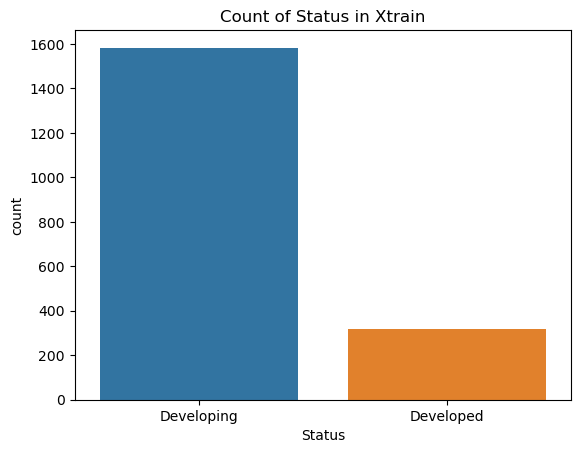

In [8]:
print(Xtrain['Status'].unique())
print(Xtrain['Status'].value_counts())
sns.countplot(x='Status', data=Xtrain)
plt.title('Count of Status in Xtrain')
plt.show()

Většina států je rozvojových.

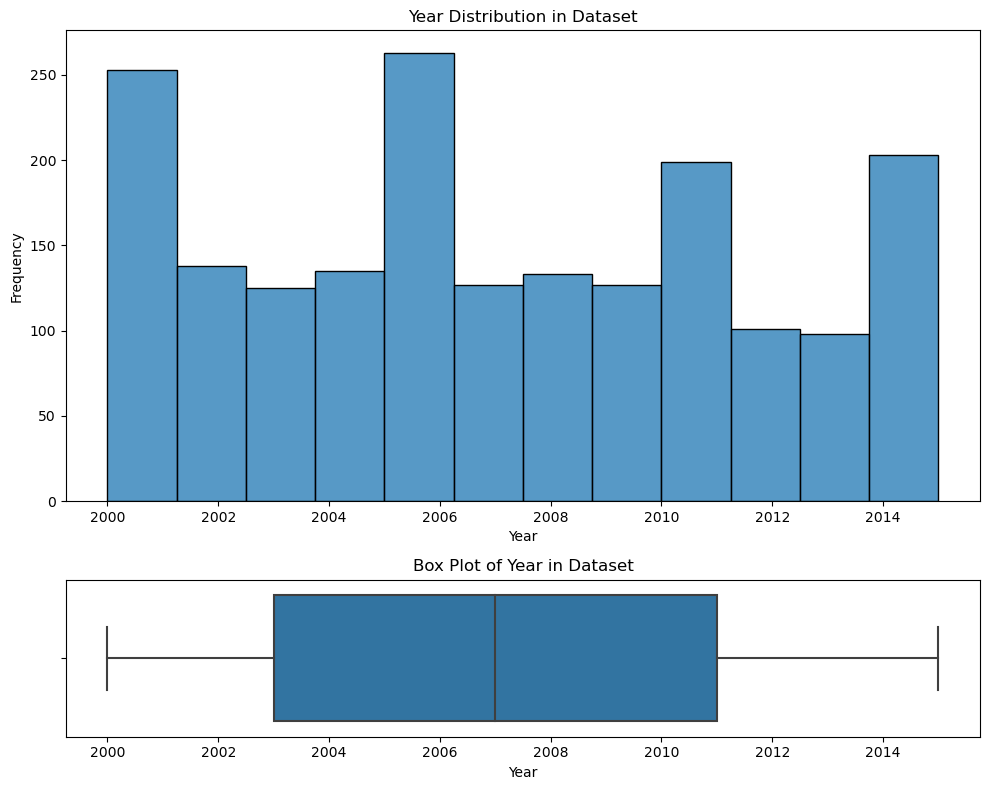

count    1902.000000
mean     2007.032072
std         4.514460
min      2000.000000
25%      2003.000000
50%      2007.000000
75%      2011.000000
max      2015.000000
Name: Year, dtype: float64

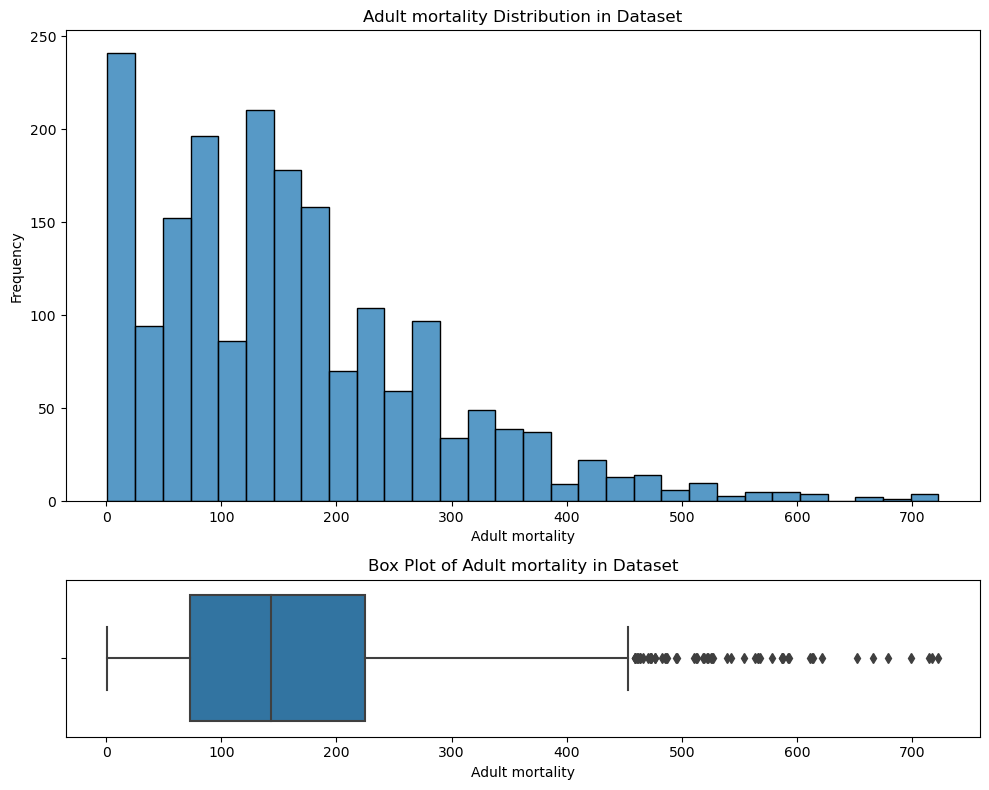

count    1902.000000
mean      162.570452
std       122.351358
min         1.000000
25%        73.000000
50%       143.000000
75%       225.000000
max       723.000000
Name: Adult Mortality, dtype: float64

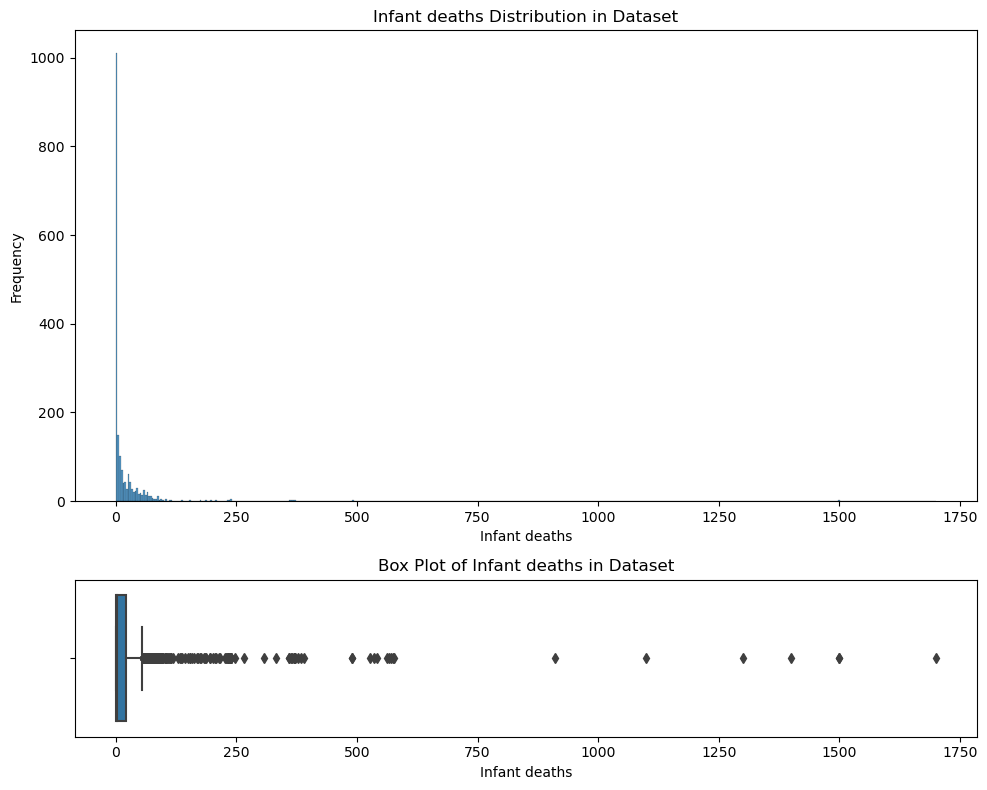

count    1902.000000
mean       27.290221
std       100.168296
min         0.000000
25%         0.000000
50%         3.000000
75%        22.000000
max      1700.000000
Name: infant deaths, dtype: float64

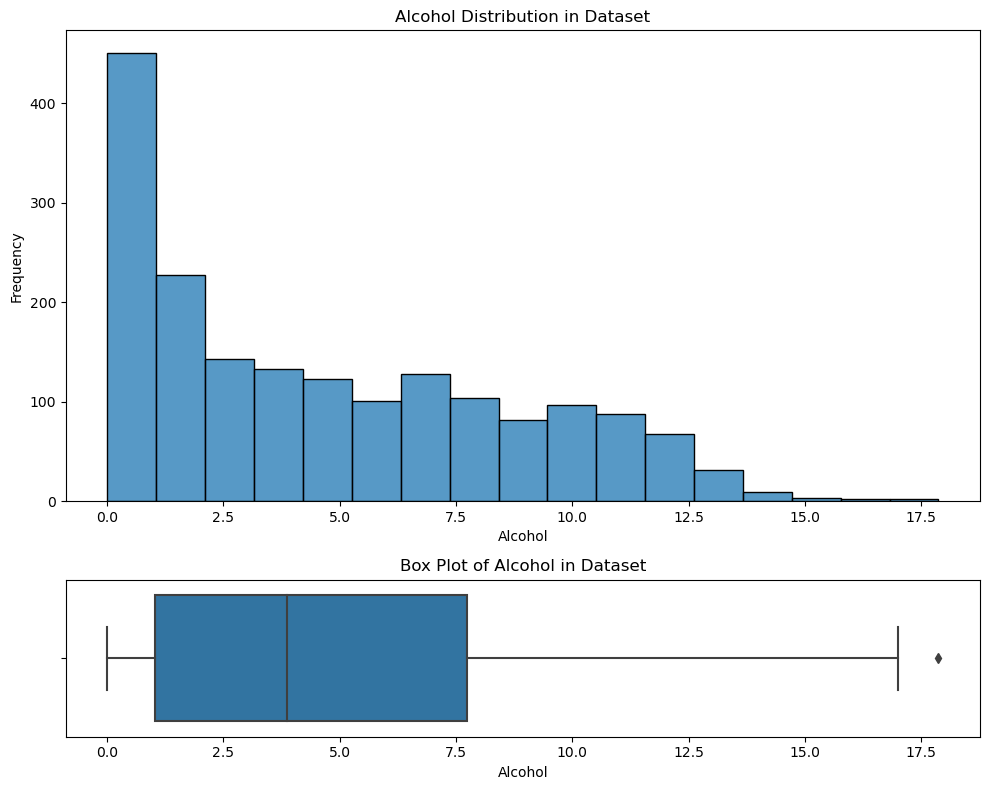

count    1792.000000
mean        4.657121
std         4.027523
min         0.010000
25%         1.030000
50%         3.875000
75%         7.742500
max        17.870000
Name: Alcohol, dtype: float64

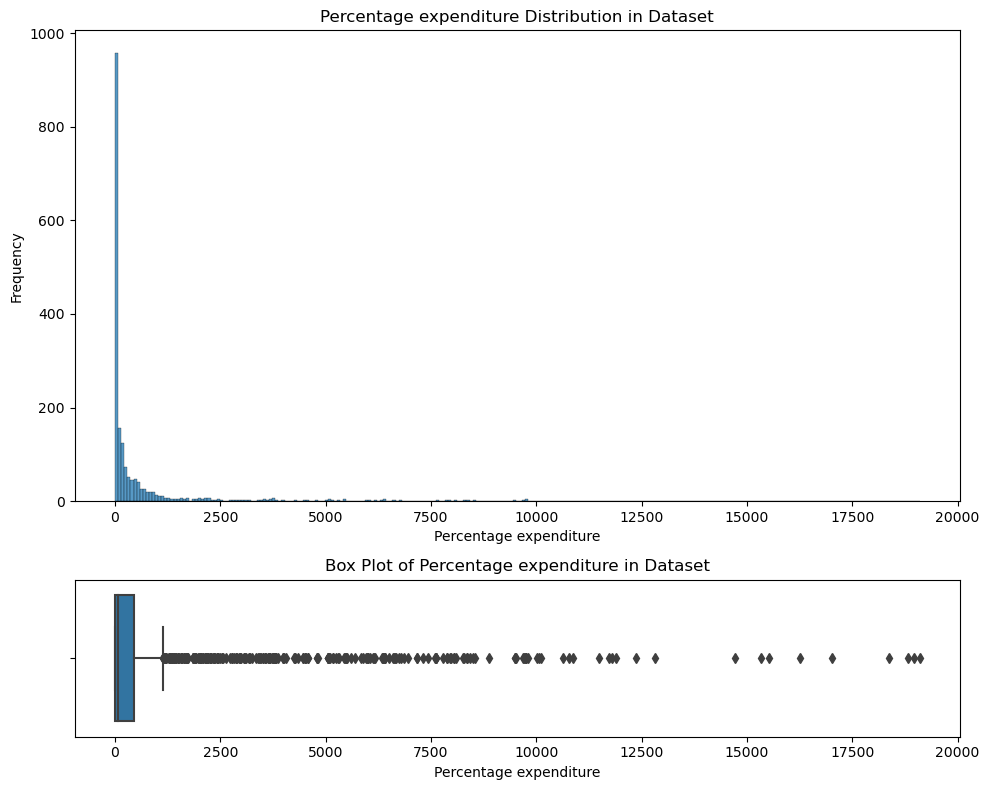

count     1902.000000
mean       789.101154
std       2080.583865
min          0.000000
25%          5.885202
50%         70.884857
75%        460.264412
max      19099.045060
Name: percentage expenditure, dtype: float64

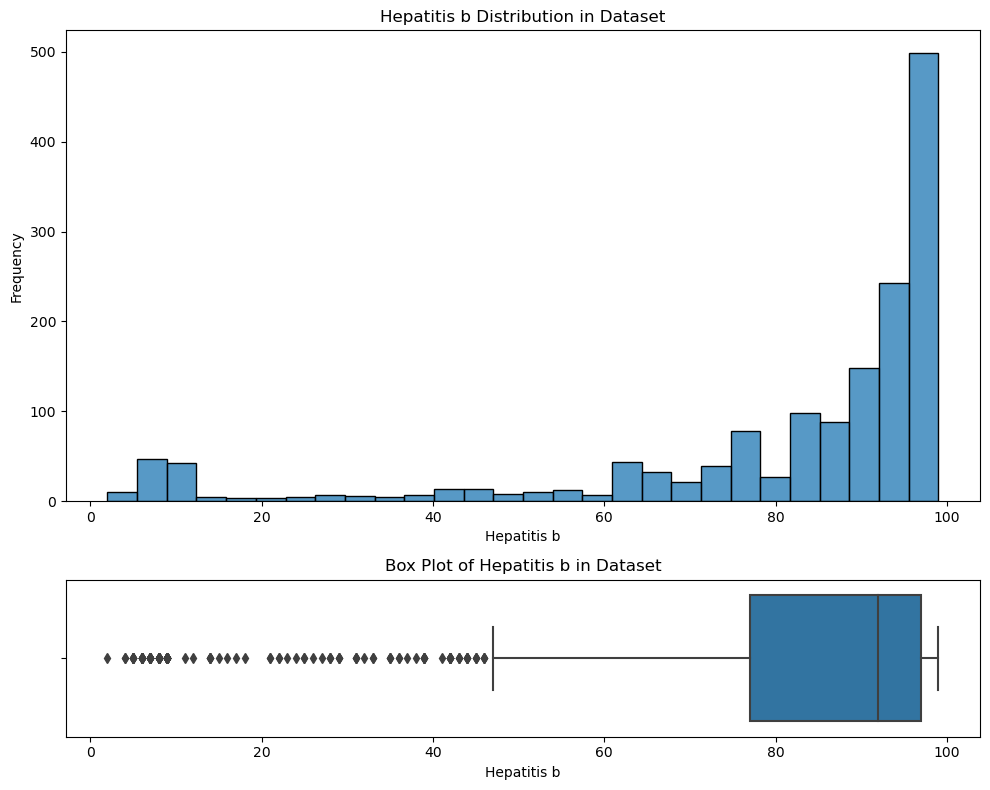

count    1522.000000
mean       81.031537
std        24.953217
min         2.000000
25%        77.000000
50%        92.000000
75%        97.000000
max        99.000000
Name: Hepatitis B, dtype: float64

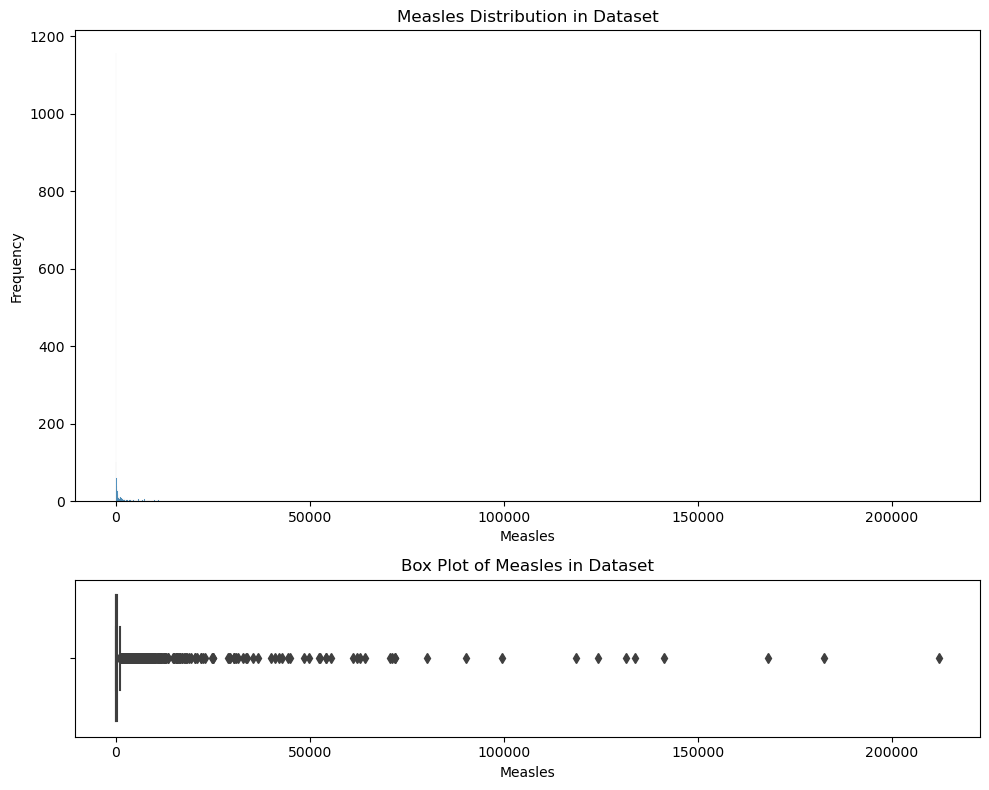

count      1902.000000
mean       2633.532072
std       12590.979369
min           0.000000
25%           0.000000
50%          18.000000
75%         404.500000
max      212183.000000
Name: Measles, dtype: float64

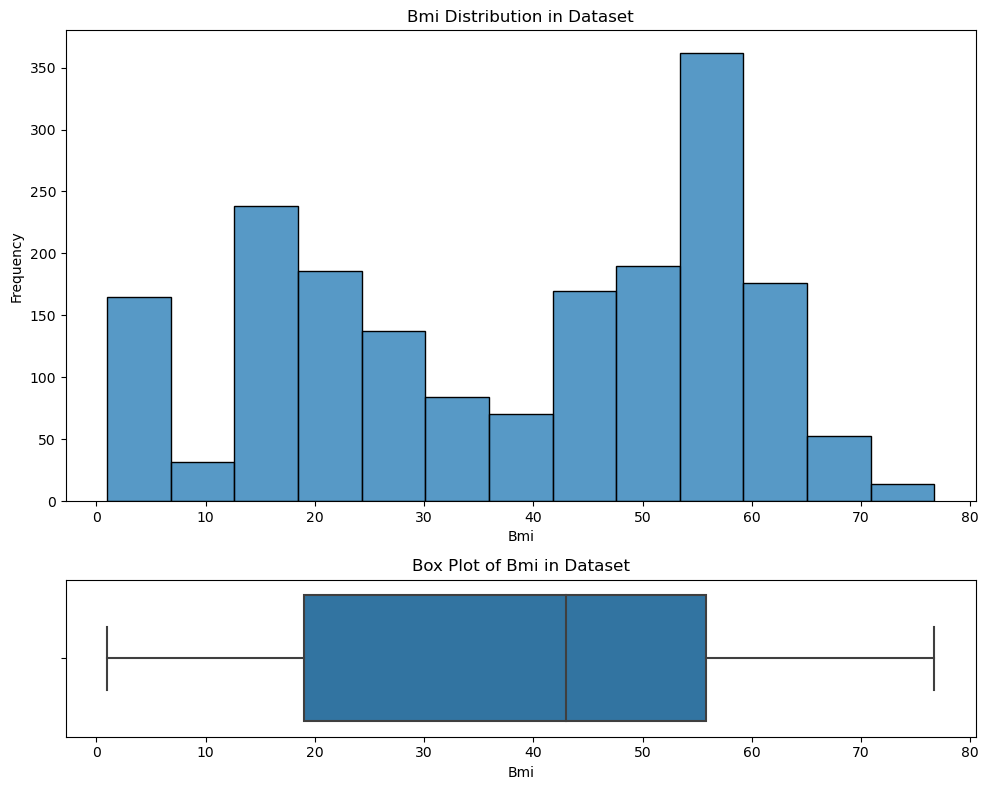

count    1877.000000
mean       37.897123
std        19.711130
min         1.000000
25%        19.000000
50%        43.000000
75%        55.800000
max        76.700000
Name: BMI, dtype: float64

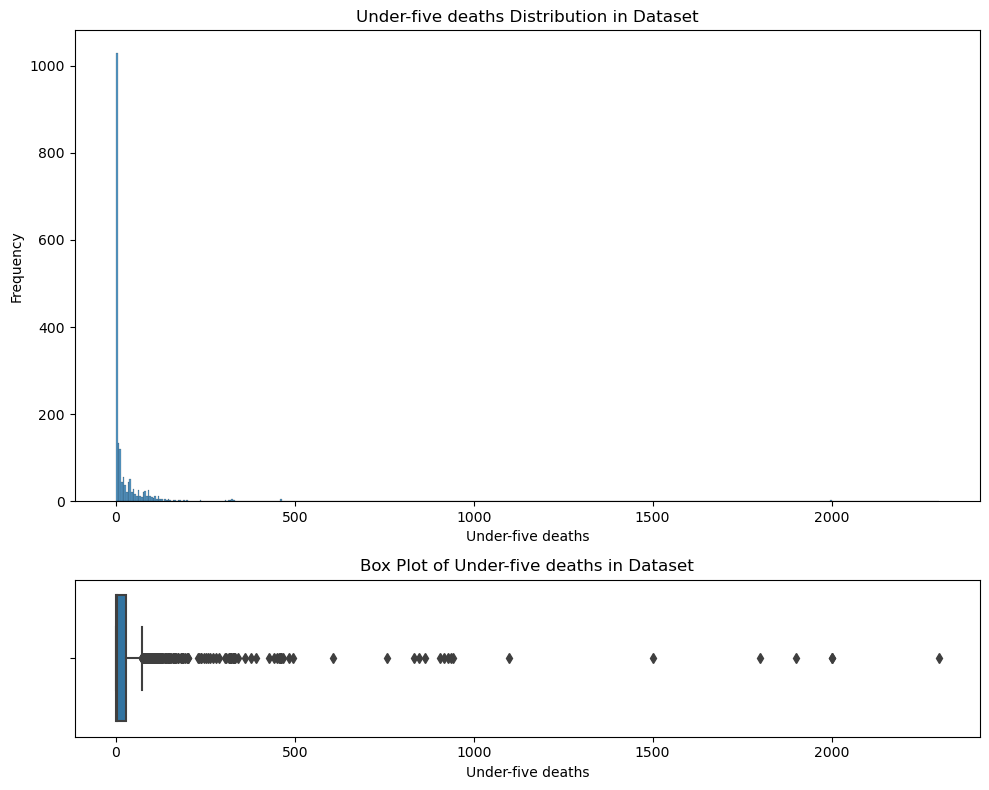

count    1902.000000
mean       37.954259
std       138.014639
min         0.000000
25%         0.000000
50%         4.000000
75%        29.000000
max      2300.000000
Name: under-five deaths, dtype: float64

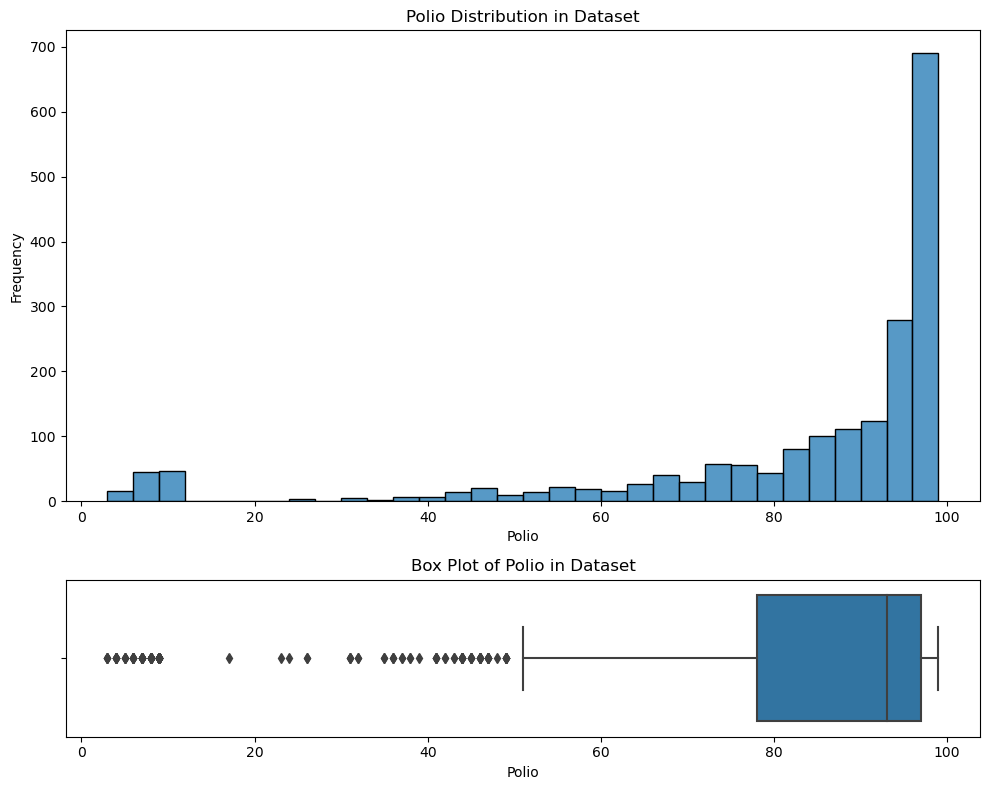

count    1887.000000
mean       82.750397
std        23.273985
min         3.000000
25%        78.000000
50%        93.000000
75%        97.000000
max        99.000000
Name: Polio, dtype: float64

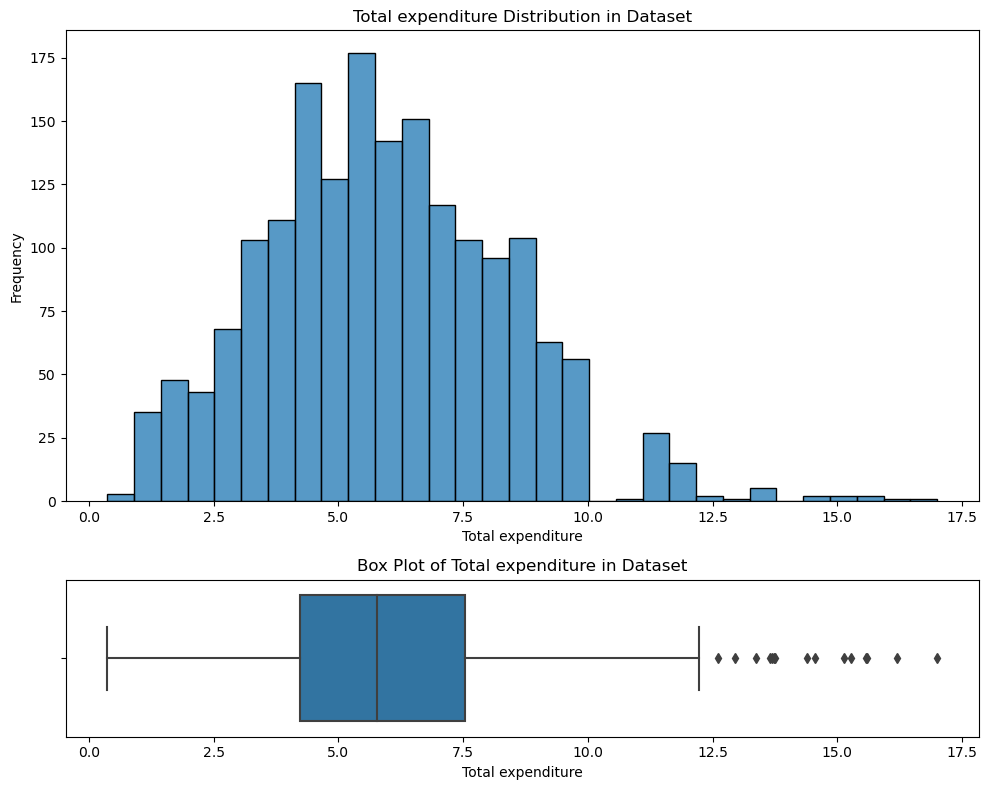

count    1771.000000
mean        5.919842
std         2.431503
min         0.370000
25%         4.240000
50%         5.770000
75%         7.530000
max        17.000000
Name: Total expenditure, dtype: float64

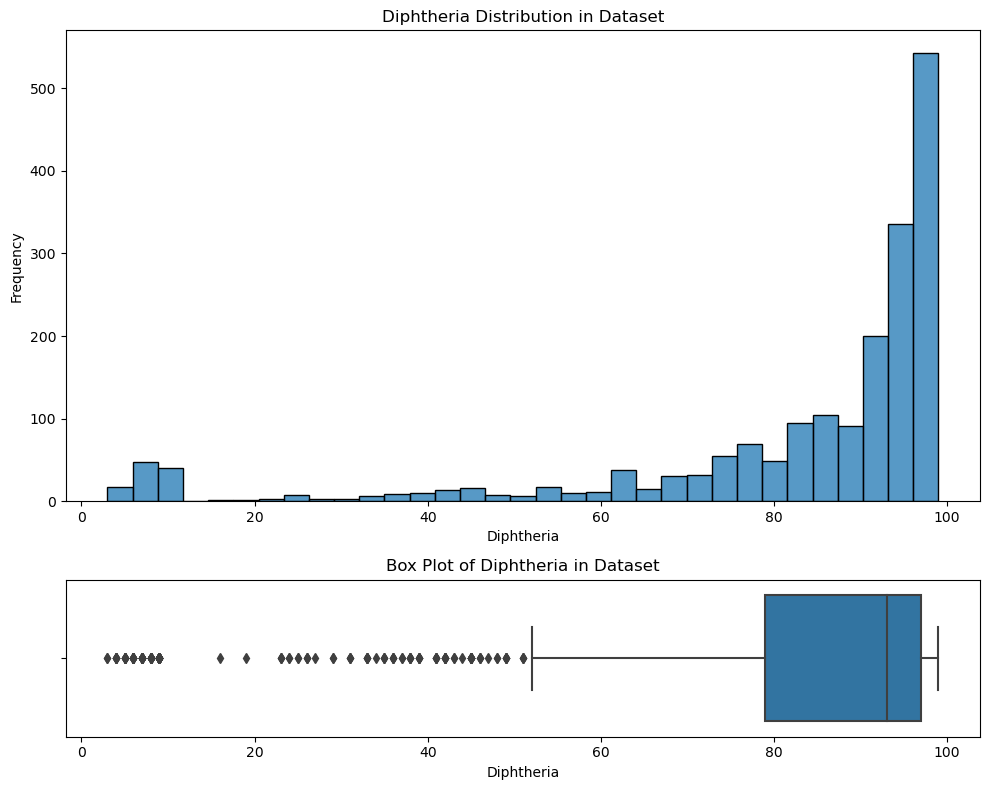

count    1887.000000
mean       82.644409
std        23.393680
min         3.000000
25%        79.000000
50%        93.000000
75%        97.000000
max        99.000000
Name: Diphtheria, dtype: float64

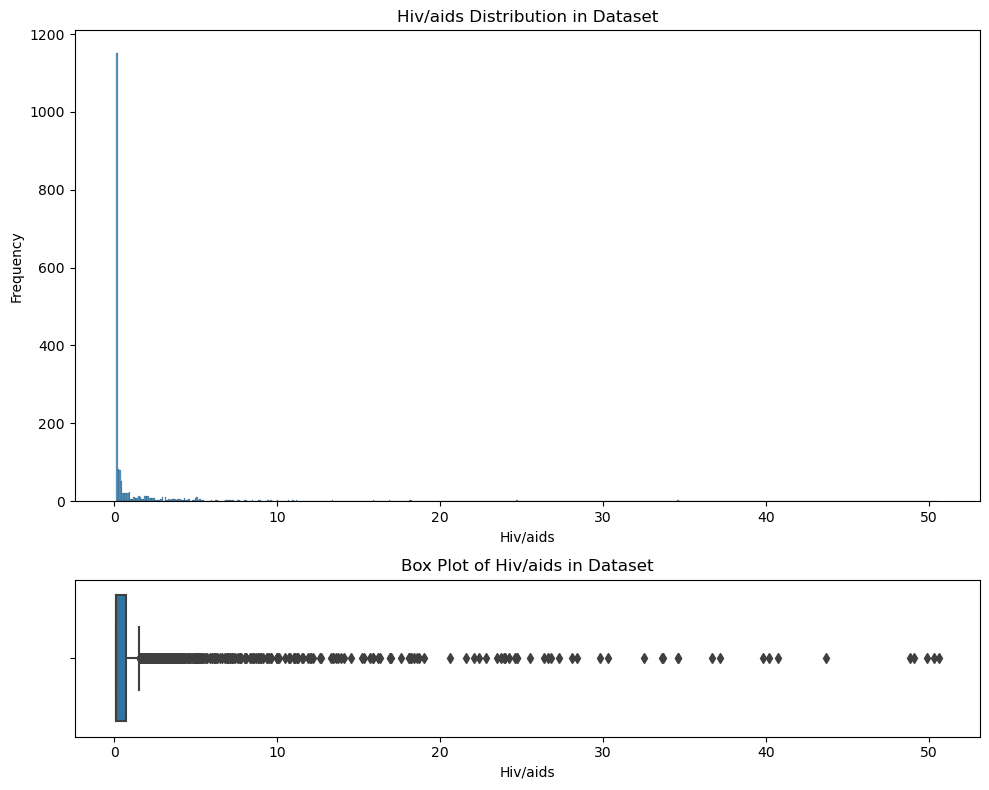

count    1902.000000
mean        1.785804
std         5.216238
min         0.100000
25%         0.100000
50%         0.100000
75%         0.700000
max        50.600000
Name: HIV/AIDS, dtype: float64

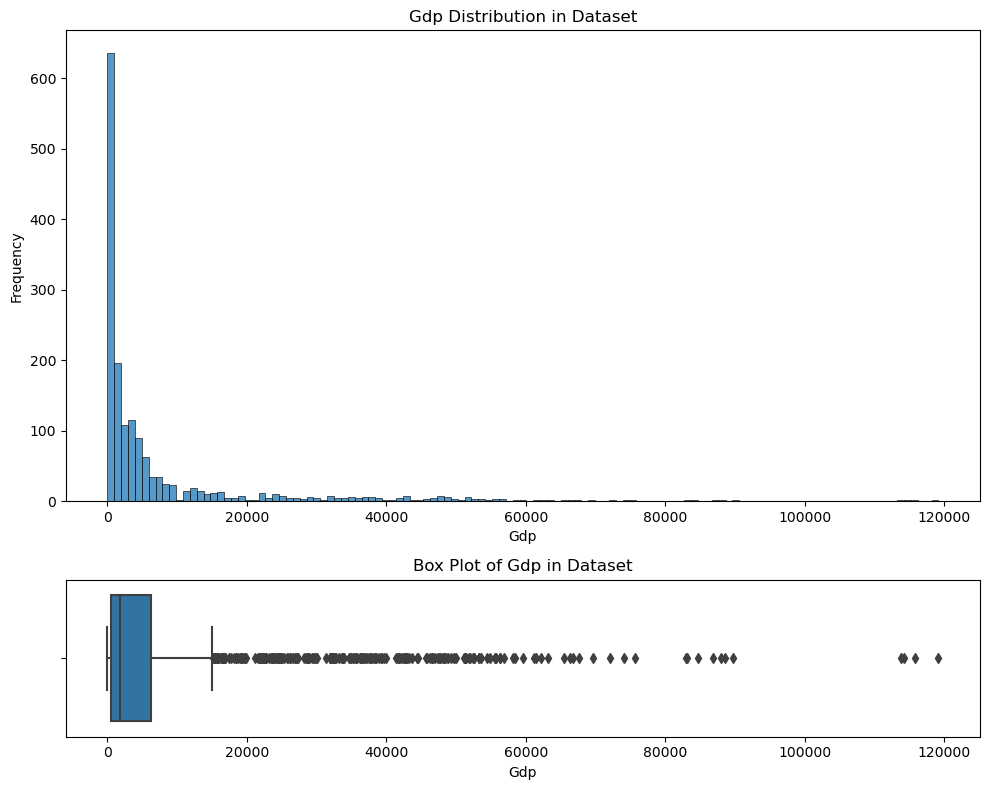

count      1621.000000
mean       7750.165574
std       14771.947402
min           1.681350
25%         453.351155
50%        1855.939150
75%        6268.692122
max      119172.741800
Name: GDP, dtype: float64

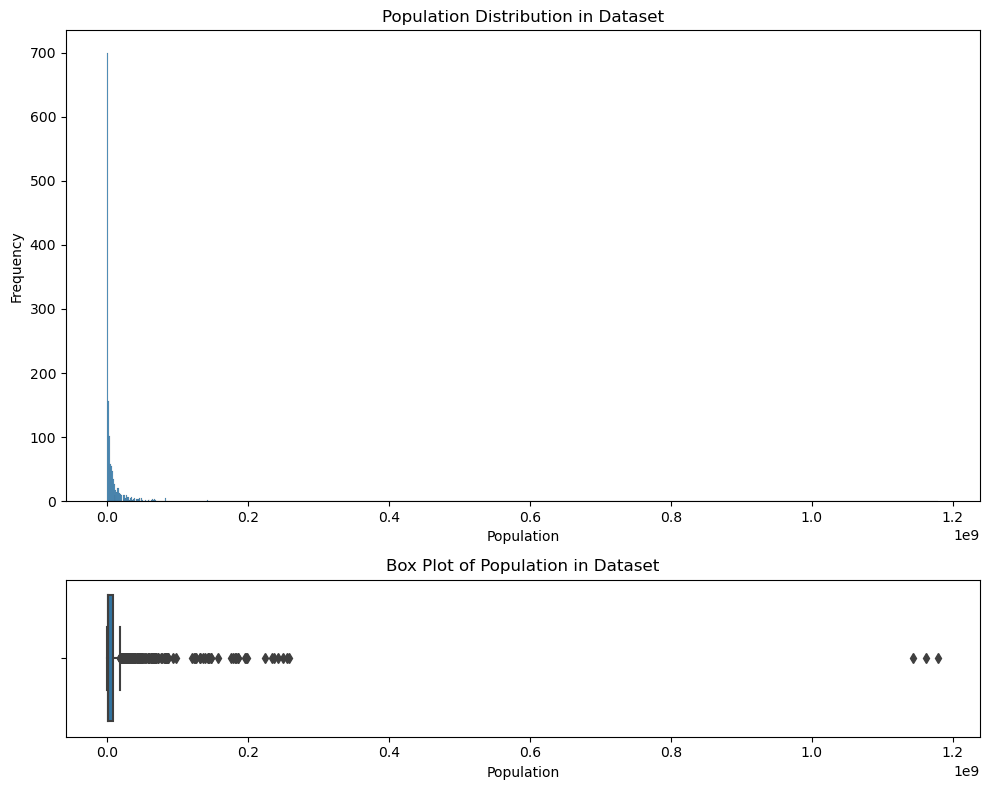

count    1.476000e+03
mean     1.294841e+07
std      5.912371e+07
min      3.600000e+01
25%      1.989615e+05
50%      1.396804e+06
75%      7.414499e+06
max      1.179681e+09
Name: Population, dtype: float64

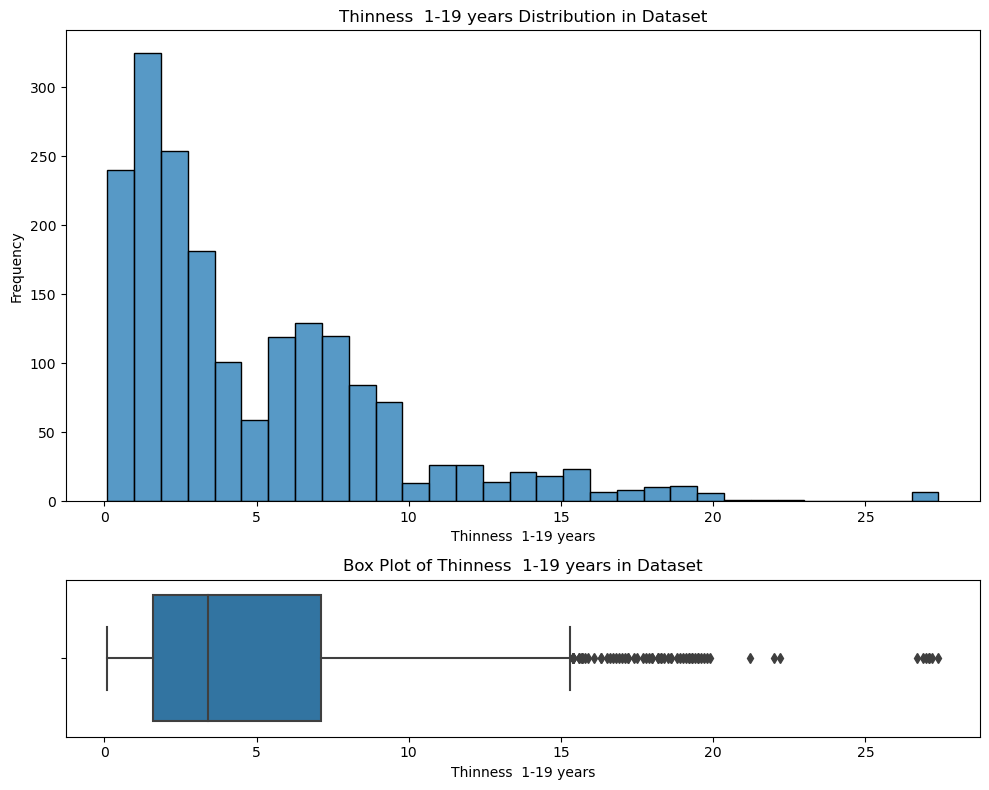

count    1877.000000
mean        4.867608
std         4.386510
min         0.100000
25%         1.600000
50%         3.400000
75%         7.100000
max        27.400000
Name: thinness  1-19 years, dtype: float64

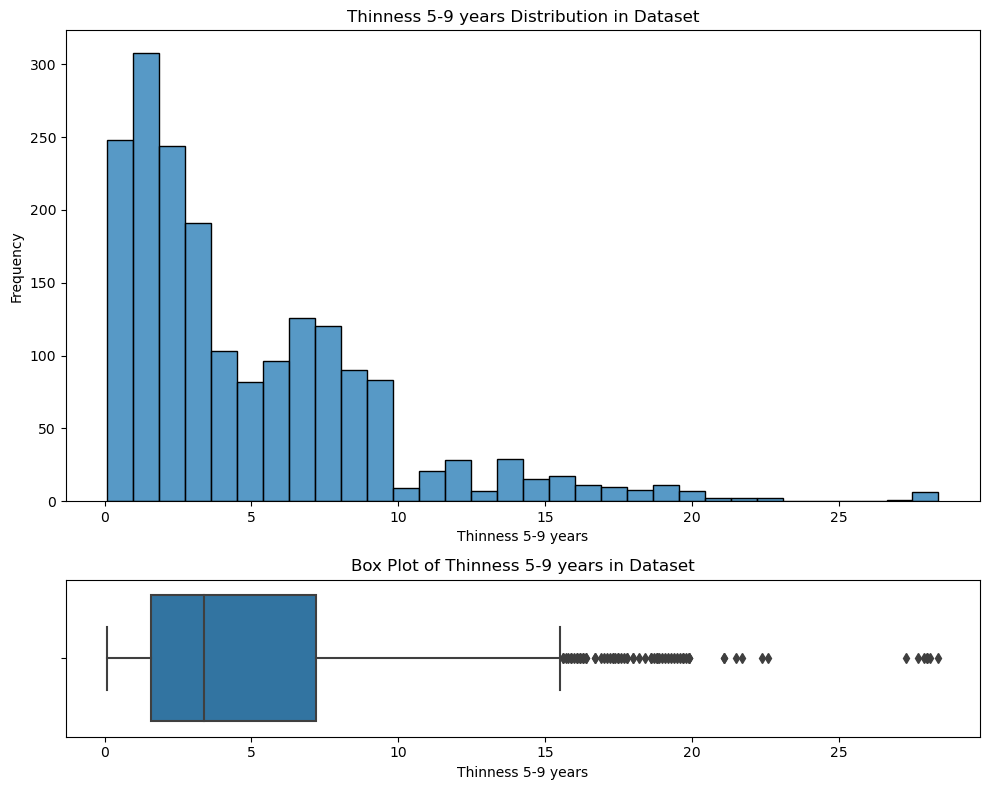

count    1877.000000
mean        4.905541
std         4.461883
min         0.100000
25%         1.600000
50%         3.400000
75%         7.200000
max        28.400000
Name: thinness 5-9 years, dtype: float64

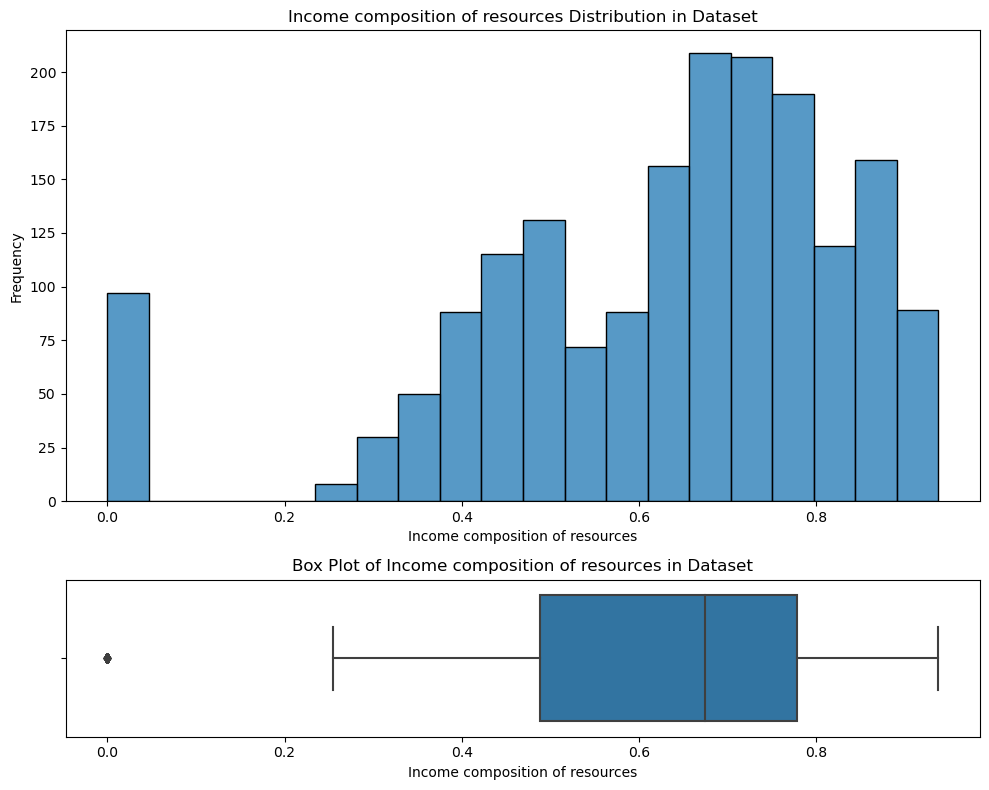

count    1808.000000
mean        0.622949
std         0.217410
min         0.000000
25%         0.488000
50%         0.675000
75%         0.778250
max         0.938000
Name: Income composition of resources, dtype: float64

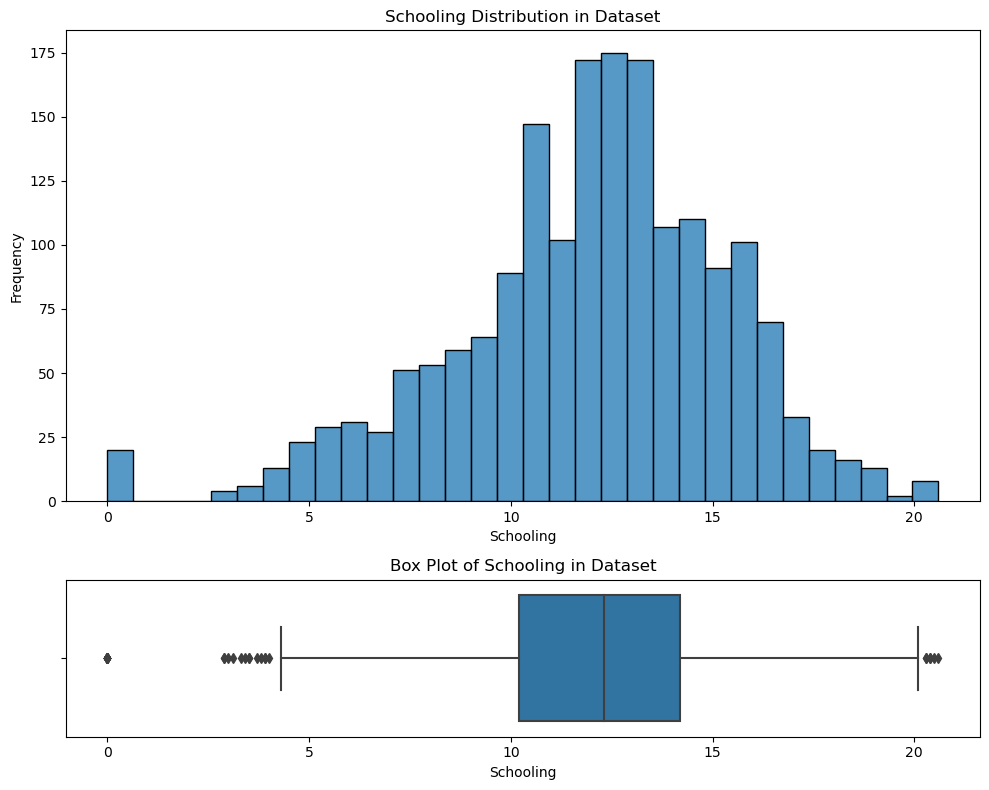

count    1808.000000
mean       11.945962
std         3.393316
min         0.000000
25%        10.200000
50%        12.300000
75%        14.200000
max        20.600000
Name: Schooling, dtype: float64

In [9]:
for column in Xtrain.columns:
    if Xtrain[column].dtype in [np.float64, np.int64]:
        hist_box(Xtrain, column, 'auto')

Vidíme, že distribuce a rozsahy hodnot jednotlivých příznaků se hodně liší, jsou různě zešikmené atd. Bude vhodné data nějakým způsobem před použitím znormalizovat.

### Doplnění chybějících hodnot, úprava datasetu

Chybějící hodnoty doplním vždy průměrem pro daný sloupec trénovacího datasetu. Odstraním sloupec Country, jedná se, de facto, o identifikátor. S příznakem Status se vypořádám one-hot encodingem, ale vytvořím pouze jeden sloupec indikující příslušnost do jedné z množin aby nevznikly zbytečné kolinérní sloupce (pokud dataset zpracovávám pro regresi, pro les nechávám oba).

In [10]:
def transform_cat_data(df, drop_first=True):
    df = pd.get_dummies(df, columns=['Status'], drop_first=drop_first)
    return df

def preprocess_data(train_df, val_df, test_df ,colsToDrop=[], drop_first=True):
    datasets = [train_df, val_df, test_df]
    for i in range(len(datasets)):
        if (not datasets[i].empty):
            datasets[i] = datasets[i].drop(columns=colsToDrop)
            datasets[i] = transform_cat_data(datasets[i], drop_first)

    column_means = train_df.select_dtypes(include=['number']).mean()
    for i in range(len(datasets)):
        datasets[i] = datasets[i].fillna(column_means)
    
    train_df, val_df, test_df = datasets
    return train_df, val_df, test_df

### Korelace, Kolinearita

In [11]:
dfcorr = Xtrain.corr()
dfcorr.style.background_gradient(cmap="coolwarm")

,Year,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
Year,1.000000,-0.065373,-0.026794,-0.049255,0.054698,0.136388,-0.085187,0.101714,-0.033859,0.119227,0.074181,0.151298,-0.119331,0.116775,0.021980,-0.020450,-0.021563,0.249631,0.214171
Adult Mortality,-0.065373,1.000000,0.068703,-0.197111,-0.251839,-0.177221,0.034382,-0.380970,0.082111,-0.276898,-0.129384,-0.289733,0.475045,-0.299456,-0.035851,0.296710,0.307043,-0.440090,-0.443403
infant deaths,-0.026794,0.068703,1.000000,-0.123339,-0.092713,-0.223479,0.491807,-0.230282,0.995909,-0.186936,-0.131826,-0.197280,0.031737,-0.113679,0.625544,0.414663,0.421005,-0.155339,-0.198467
Alcohol,-0.049255,-0.197111,-0.123339,1.000000,0.360855,0.076162,-0.050398,0.353633,-0.118056,0.223955,0.311560,0.230042,-0.041605,0.376329,-0.039771,-0.442637,-0.430491,0.444803,0.552505
percentage expenditure,0.054698,-0.251839,-0.092713,0.360855,1.000000,0.007636,-0.058964,0.241253,-0.094330,0.157333,0.198827,0.160635,-0.101447,0.914094,-0.025079,-0.264039,-0.266788,0.386508,0.387200
Hepatitis B,0.136388,-0.177221,-0.223479,0.076162,0.007636,1.000000,-0.109393,0.171087,-0.232783,0.468480,0.070524,0.598387,-0.114424,0.081420,-0.146848,-0.111006,-0.124268,0.189842,0.231242
Measles,-0.085187,0.034382,0.491807,-0.050398,-0.058964,-0.109393,1.000000,-0.167564,0.502035,-0.150338,-0.104419,-0.160387,0.039300,-0.076883,0.211312,0.198929,0.194484,-0.146743,-0.139991
BMI,0.101714,-0.380970,-0.230282,0.353633,0.241253,0.171087,-0.167564,1.000000,-0.240538,0.307490,0.245913,0.311714,-0.235541,0.315762,-0.069499,-0.538818,-0.548666,0.505765,0.561613
under-five deaths,-0.033859,0.082111,0.995909,-0.118056,-0.094330,-0.232783,0.502035,-0.240538,1.000000,-0.205726,-0.132347,-0.218384,0.045248,-0.116927,0.608743,0.418396,0.425107,-0.175659,-0.214339
Polio,0.119227,-0.276898,-0.186936,0.223955,0.157333,0.468480,-0.150338,0.307490,-0.205726,1.000000,0.137891,0.662208,-0.157458,0.221841,-0.041686,-0.237768,-0.238532,0.377763,0.423107


Vidíme, že některé příznaky jsou silně korelované. Proto jako jeden z modelů zvolím hřebenovou regresi.

### Příprava pro model hřebenové regrese

Provedu standardizaci numerických příznaků. Data mají různě zešikmená rozdělení v různých rozsazích. Pro zvýšení přesnosti použiji polynomiální bázové funkce, které umožní odhadnout i nealinérní závisloti -> polynomiální regrese. Odstraním sloupce, které jsou silně korelované s jinými příznaky: GDP, percentage expenditure, infant deaths (v datasetu je příznak under-five deaths, z definice budou silně korelované) a odstraním též Population, protože obsahuje hodně chybějícíh hodnot.

In [12]:
def scale_data(train_df, val_df, test_df, scaler):
    cols_to_scale = train_df.columns.difference(['Year'])
    
    scaler = scaler.fit(train_df[cols_to_scale])

    train_df[cols_to_scale] = scaler.transform(train_df[cols_to_scale])
    val_df[cols_to_scale] = scaler.transform(val_df[cols_to_scale])
    test_df[cols_to_scale] = scaler.transform(test_df[cols_to_scale])
    
    return train_df, val_df, test_df

def pipeline_ridge(train_df, val_df, test_df, scaler=StandardScaler()):
    train_df, val_df, test_df = preprocess_data(train_df, val_df, test_df, ['Country', 'GDP', 'Population', 'infant deaths', 'percentage expenditure'])

    poly = PolynomialFeatures(degree=4)
    train_poly = poly.fit_transform(train_df)
    val_poly = poly.transform(val_df)
    test_poly = poly.transform(test_df)
    feature_names = poly.get_feature_names_out(train_df.columns)
    train_df = pd.DataFrame(train_poly, columns=feature_names, index=train_df.index)
    val_df = pd.DataFrame(val_poly, columns=feature_names, index=val_df.index)
    test_df = pd.DataFrame(test_poly, columns=feature_names, index=test_df.index)
    
    train_df, val_df, test_df = scale_data(train_df, val_df, test_df, StandardScaler())
    return train_df, val_df, test_df

## Ladění modelů

### Hřebenová regrese

In [13]:
def get_opt_ridge_model(Xtrain, Xval, ytrain, yval):
    def ridgemodel_eval(alpha):
        clf = Ridge(alpha=alpha)
        clf.fit(Xtrain, ytrain)
        return np.sqrt(mean_squared_error(yval, clf.predict(Xval)))

    opt_alpha = optimize.minimize_scalar(ridgemodel_eval, options = {'maxiter': 10000}, method = 'bounded', bounds=(0, 10000))
    print('Optimal alpha', opt_alpha)
    print("\n")

    clf_opt_ridge = Ridge(alpha = opt_alpha.x)
    clf_opt_ridge.fit(Xtrain, ytrain)
    return clf_opt_ridge

def print_metrics(model ,yval, Xval):
    RMSE_val_opt_ridge = np.sqrt(mean_squared_error(yval, model.predict(Xval)))
    MAE_val_opt_ridge = mean_absolute_error(yval, model.predict(Xval))
    print(f'RMSE: {RMSE_val_opt_ridge:.5f}')
    print(f'MAE: {MAE_val_opt_ridge:.5f}')

In [14]:
Xtrain_sc, Xval_sc, Xtest_sc = pipeline_ridge(Xtrain, Xval, Xtest)

In [15]:
clf_opt_ridge = get_opt_ridge_model(Xtrain_sc, Xval_sc, ytrain, yval)
print_metrics(clf_opt_ridge, yval, Xval_sc)

Optimal alpha  message: Solution found.
 success: True
  status: 0
     fun: 2.443814086597114
       x: 75.87771185548783
     nit: 24
    nfev: 24


RMSE: 2.44381
MAE: 1.73795


Dosáhli jsme RMSE: 2.44381 s alpha = 75.877. 

### Náhdoný les

Rozhodl jsem se použít parametr max_samples jako relativní počet bodů.

In [16]:
class CustomRandomForest:

    def __init__(self, n_estimators, max_samples, max_depth, random_state = 42, **kwargs):
        """
        Konstruktor modelu
        Základní hyperparametery:
            n_estimators - počet podmodelů - rozhodovacích stromů.
            max_samples - relativní počet bodů (tj. číslo mezi 0 a 1) 
            max_depth - maximální hloubka každého z podmodelů rozhodovacího stromu.
            kwargs - (volitelně) případné další hyperparametry, které pošlete do podmodelů rozhodovacího stromu
        """
        self.n_estimators = n_estimators
        self.max_samples = max_samples
        self.max_depth = max_depth
        self.kwargs = kwargs
        self.models = []
        self.random_state = random_state
        pass
        
    def fit(self, X, y):
        """
        Natrénování modelu. Trénovací data jsou v argumentech X a y.
        """
        n_samples = len(X)
        rng = np.random.default_rng(self.random_state)
        for _ in range(self.n_estimators):
            if 0 < self.max_samples <= 1: 
                n_bootstrap = int(self.max_samples * n_samples)
            else:
                raise ValueError("max_samples must be a fraction between 0 and 1")
            
            # Bootstrap sampling
            bootstrap_indices = rng.choice(np.arange(n_samples), size=n_bootstrap, replace=True)
            X_bootstrap = X.iloc[bootstrap_indices]
            y_bootstrap = y.iloc[bootstrap_indices]
            
            # Train a DecisionTreeRegressor
            tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=self.random_state ,**self.kwargs)
            tree.fit(X_bootstrap, y_bootstrap)
            self.models.append(tree)
        
        return self
        
    def predict(self, X):
        """
        Predikce y v zadaných bodech X
        """
        predictions = np.zeros((len(self.models), X.shape[0]))
        for i, tree in enumerate(self.models):
            predictions[i] = tree.predict(X)
        
        y_predicted = predictions.mean(axis=0)
        return y_predicted

In [17]:
def pipeline_tree(train_df, val_df, test_df, scaler=StandardScaler()):
    train_df, val_df, test_df = preprocess_data(train_df, val_df, test_df, ['Country'], False)
    return train_df, val_df, test_df

In [18]:
def train_model(param_grid, Xtrain, ytrain, Xval, yval, model_type, random_state=None):
    param_comb = ParameterGrid(param_grid)
    val_RMSE = []
    val_MAE = []
    for params in param_comb:
        if(random_state == None):
            model = model_type(**params).fit(Xtrain, ytrain)
        else:
            model = model_type(**params, random_state = random_state).fit(Xtrain, ytrain)
    
        val_RMSE.append(np.sqrt(mean_squared_error(yval, model.predict(Xval))))
        val_MAE.append(mean_absolute_error(yval, model.predict(Xval)))

    best_params = param_comb[np.argmin(val_RMSE)]
    print(f"We found the best params {best_params} with validation \nRMSE: {min(val_RMSE):.5f} \nMAE: {val_MAE[np.argmin(val_RMSE)]:.5f}")
    if(random_state == None):
        best_model = model_type(**best_params).fit(Xtrain, ytrain)
    else:
        best_model = model_type(**best_params, random_state= rd_seed).fit(Xtrain, ytrain)
    return best_model

In [19]:
Xtrain_t, Xval_t, Xtest_t = pipeline_tree(Xtrain, Xval, Xtest)

In [20]:
param_grid = {
    'n_estimators': range(5, 40, 5),
    'max_depth': range(1, 12),
    'max_samples': [0.5, 0.7, 1.0]
}

custom_forest = train_model(param_grid, Xtrain_t, ytrain, Xval_t, yval, CustomRandomForest, rd_seed)

We found the best params {'n_estimators': 25, 'max_samples': 0.7, 'max_depth': 11} with validation 
RMSE: 1.87592 
MAE: 1.24426


Vidíme, že les dosáhl lepšího RMSE než model hřebenové regrese.

### KNN

Jako třetí model zvolím KNN pro regresi. Důvodem je hypotéza, že státy, které mají podobné (blízké) hodnoty příznaků budou mít i podobnou průměrnou délku dožití. 

Je třeba vyzkoušet možné normalizace, protože data jsou různých rozsahů a rozdělní.

In [21]:
def pipeline_KNN(train_df, val_df, test_df, scaler=StandardScaler()):
    train_df, val_df, test_df = preprocess_data(train_df, val_df, test_df, ['Country'], True)
    train_df, val_df, test_df = scale_data(train_df, val_df, test_df, scaler)    
    return train_df, val_df, test_df

In [22]:
Xtrain_sk, Xval_sk, Xtest_sk = pipeline_KNN(Xtrain, Xval, Xtest, StandardScaler())
Xtrain_mk, Xval_mk, Xtest_mk = pipeline_KNN(Xtrain, Xval, Xtest, MinMaxScaler())

In [23]:
warnings.simplefilter(action='ignore', category=FutureWarning) 

param_grid = {
    "n_neighbors": range(1, 30),
    "weights": ["distance", "uniform"],
    "p": range(1,4),
    "metric": ["chebyshev", "minkowski"]
}

KNN_standard = train_model(param_grid, Xtrain_sk, ytrain, Xval_sk, yval, KNeighborsRegressor)
KNN_minmax = train_model(param_grid, Xtrain_mk, ytrain, Xval_mk, yval, KNeighborsRegressor)

We found the best params {'weights': 'distance', 'p': 1, 'n_neighbors': 2, 'metric': 'minkowski'} with validation 
RMSE: 2.38021 
MAE: 1.53002
We found the best params {'weights': 'distance', 'p': 1, 'n_neighbors': 5, 'metric': 'minkowski'} with validation 
RMSE: 3.83131 
MAE: 2.91185


Lepší RMSE má verze se standardizací.

## Výběr modelů

In [24]:
model_RMSE = []
model_RMSE.append(['Custom Forest', np.sqrt(mean_squared_error(yval, custom_forest.predict(Xval_t))), mean_absolute_error(yval,custom_forest.predict(Xval_t))])
model_RMSE.append(['KNN with Standardization', np.sqrt(mean_squared_error(yval, KNN_standard.predict(Xval_sk))), mean_absolute_error(yval,KNN_standard.predict(Xval_sk))])
model_RMSE.append(['Ridge Regression', np.sqrt(mean_squared_error(yval, clf_opt_ridge.predict(Xval_sc))), mean_absolute_error(yval, clf_opt_ridge.predict(Xval_sc))])

model_RMSE_df = pd.DataFrame(model_RMSE, columns=['Model', 'RMSE', 'MAE'])
display(model_RMSE_df)

,Model,RMSE,MAE
0,Custom Forest,1.875921,1.244264
1,KNN with Standardization,2.380215,1.530024
2,Ridge Regression,2.443814,1.737946


Nejlepší hodnoty RMSE pro danou úlohu má implementace náhodného lesa, proto ji vyberu jako finální model. Pomocí testovacích dat odhadnu chybu (RMSE) na nových datech.

In [25]:
print(f'Approximation of RMSE for new data: {np.sqrt(mean_squared_error(ytest, custom_forest.predict(Xtest_t)))}')

Approximation of RMSE for new data: 1.8882470255386263


## Vyhodnocovací data

In [26]:
data = pd.read_csv("evaluation.csv")
Xeval, x, y = pipeline_tree(data, pd.DataFrame(), pd.DataFrame())

result = pd.DataFrame({
    "Country": data["Country"],
    "Year": data["Year"],
    "Life expectancy": custom_forest.predict(Xeval)
})
result.to_csv("results.csv", index=False)